# Artificial Neural Networks and Deep Learning



---



## Homework 2: 

## ⚙️ Import Libraries

In [1]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import keras
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2
from tensorflow.keras import backend as K
import matplotlib as mpl

import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras import layers, Model
from tensorflow.keras.applications import ConvNeXtBase
seed = 42
np.random.seed(42)
tf.random.set_seed(42)

# custom module for augmentation
import sys
sys.path.append('/kaggle/input/aug-pipeline/')
import AugmentationHelper

/opt/conda/lib/python3.10/site-packages/albumentations/check_version.py:51: UserWarning: Error fetching version info <urlopen error [Errno -3] Temporary failure in name resolution>
  data = fetch_version_info()


## ⏳ Load the Data

In [2]:
# file_path = "/kaggle/input/mars-data/mars_for_students.npz"
file_path = "/kaggle/input/mars-data/mars_for_students_cleaned.npz"

data = np.load(file_path)

training_set = data["training_set"]
images = training_set[:, 0]
labels = training_set[:, 1]

images = images.astype(np.uint8)
labels = labels.astype(np.uint8)

print(f"Training X shape: {images.shape}")
print(f"Training y shape: {labels.shape}")

Training X shape: (2102, 64, 128)
Training y shape: (2102, 64, 128)


### Some exploration (ignore)

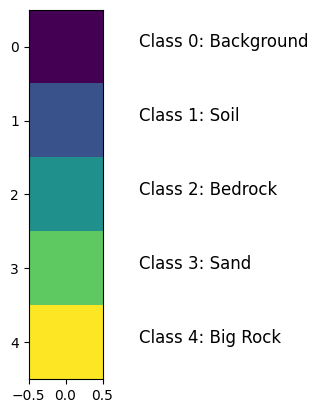

In [3]:
# Labels dictionary
labels_map = {
    0: 'Background',
    1: 'Soil',
    2: 'Bedrock',
    3: 'Sand',
    4: 'Big Rock'
}

plt.imshow([[i] for i in range(5)])
for i in range(5):
    plt.text(1, i, f'Class {i}: {labels_map[i]}', fontsize=12)

plt.show()

In [4]:
n_samples = images.shape[0]
n_samples

2102

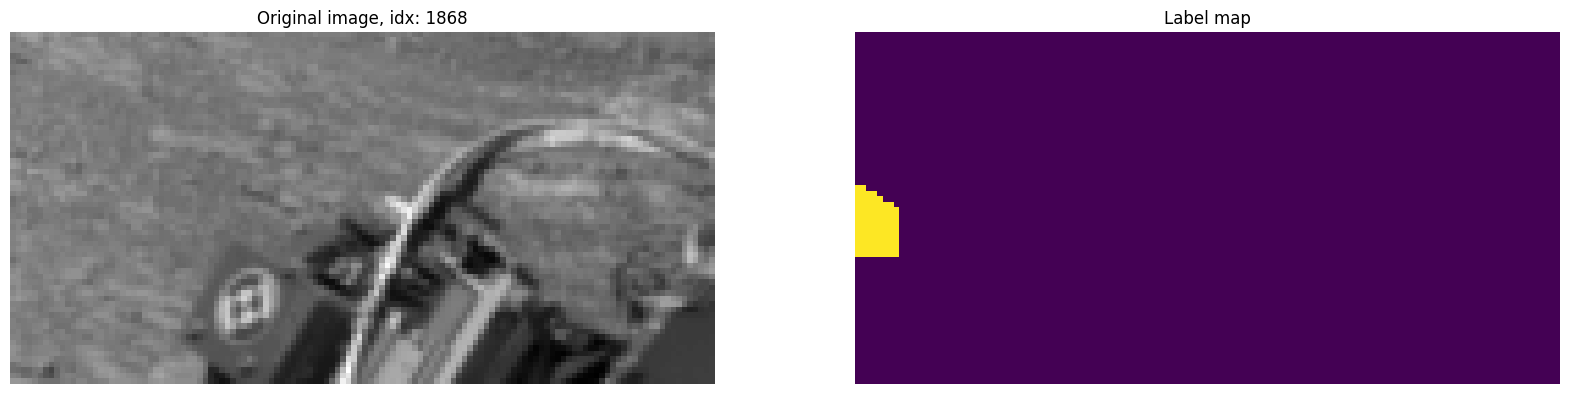

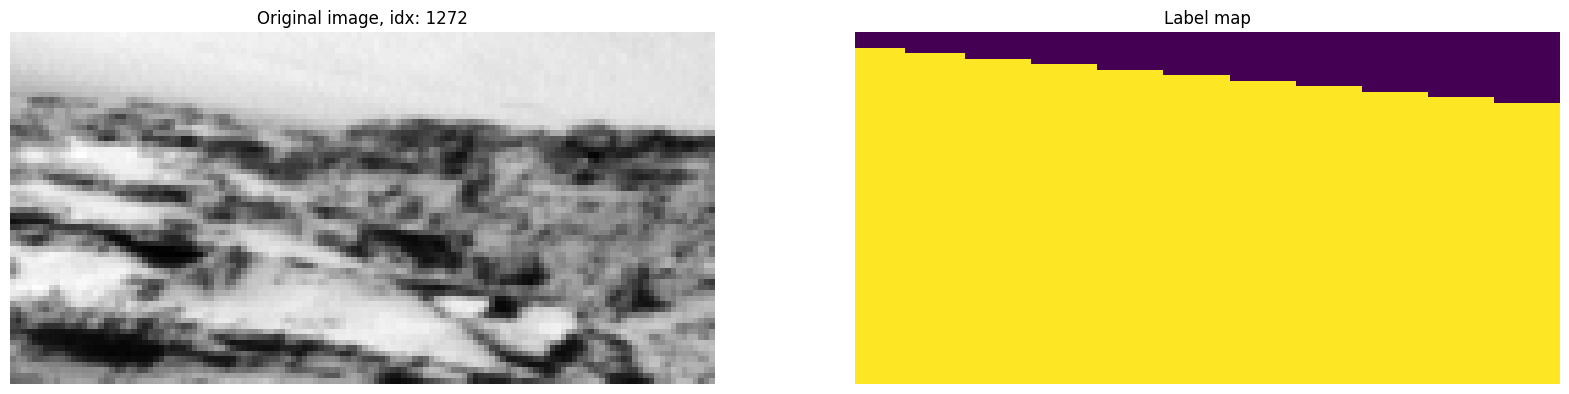

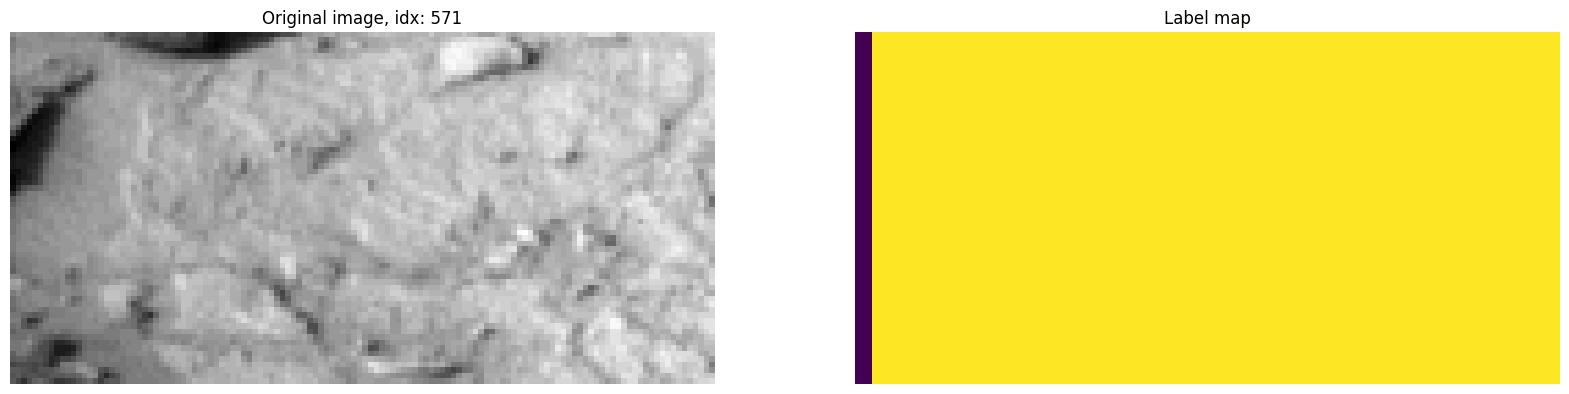

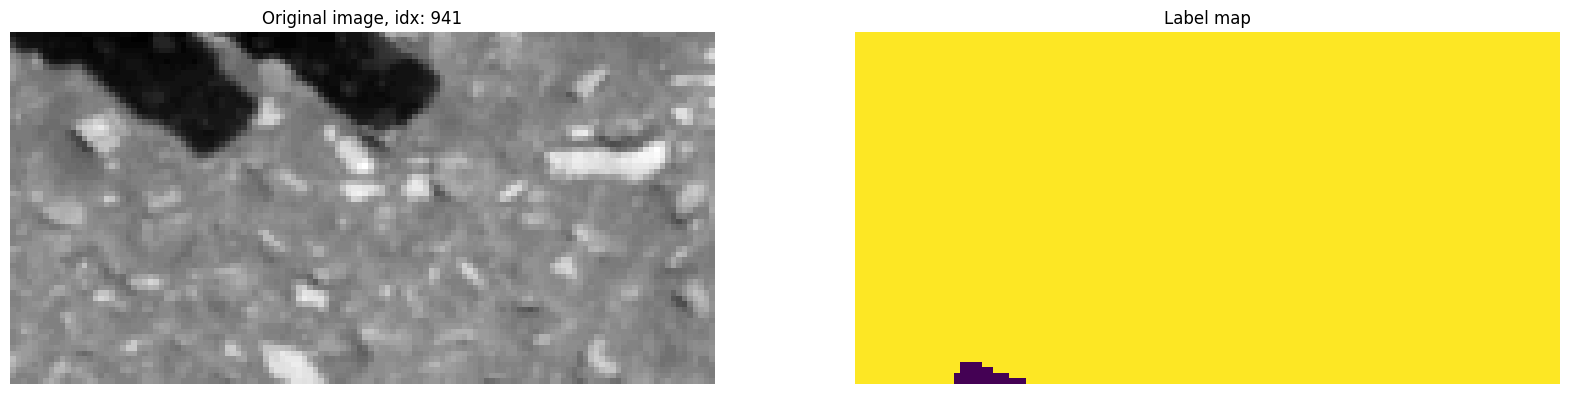

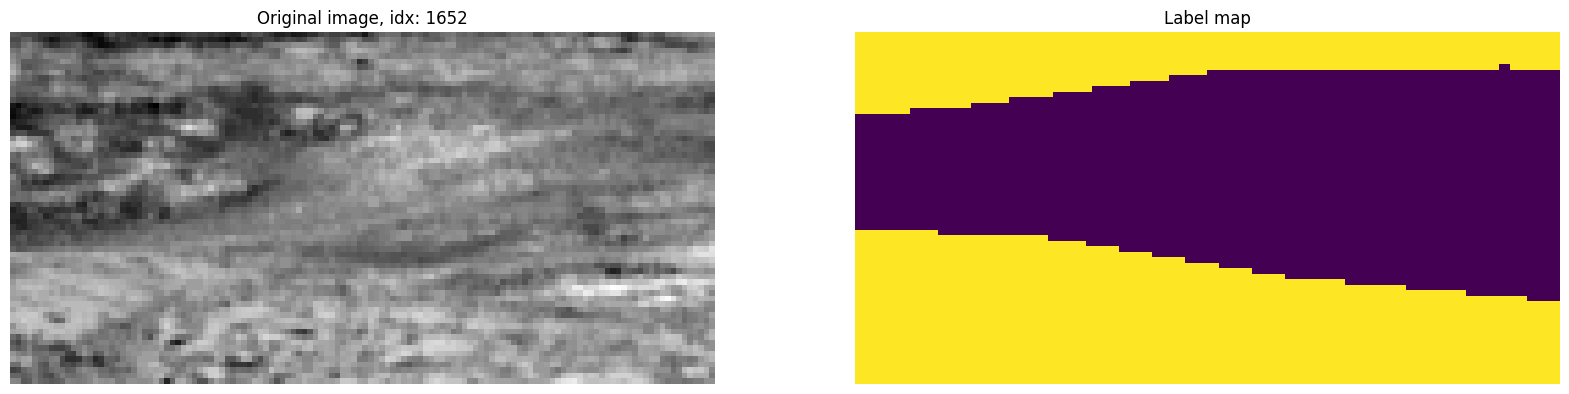

In [5]:
rand_samples = np.random.choice(n_samples, size=5, replace=False)
for sample in rand_samples:
    plt.figure(figsize=(20, 5))
    plt.subplot(121), plt.imshow(images[sample],cmap='gray'), plt.title(f'Original image, idx: {sample}'), plt.axis('off')
    plt.subplot(122), plt.imshow(labels[sample]), plt.title('Label map'), plt.axis('off')
    plt.show()

## Data splitting

In [6]:
# 10% of input data to both test and validation sets
test_ratio = 0.05 
validation_ratio = 0.05 / 0.9 

train_val_img, test_img, train_val_lbl, test_lbl = train_test_split(
    images, labels, test_size=test_ratio, random_state=seed
)

train_img, val_img, train_lbl, val_lbl = train_test_split(
    train_val_img, train_val_lbl, test_size=validation_ratio, random_state=seed
)

print(f"Number of images")
print(f"Train: \t\t{len(train_img)}")
print(f"Validation: \t{len(val_img)}")
print(f"Test: \t\t{len(test_img)}")

Number of images
Train: 		1885
Validation: 	111
Test: 		106


In [7]:
# Set number of classes
NUM_CLASSES = 5

# Set batch size for training
BATCH_SIZE = 64

# Set learning rate for the optimiser
LEARNING_RATE = 1e-3

# Set early stopping patience threshold
PATIENCE = 30

# Set maximum number of training epochs
EPOCHS = 1000

## Preprocessing

In [ ]:
"Size of train dataset after augmentation", len(train_img)

In [8]:
def one_hot_encoding(image, mask):
    num_classes = 5
    tf.ensure_shape(mask, (64, 128))
    mask = tf.one_hot(mask, depth=num_classes, dtype=tf.uint8)
    print(mask.shape)
    return image, mask

# Reshape the input images to (64, 128, 1) and normalise to [0,1]
def reshape_input(image, mask):
    scaled_image = tf.cast(image, tf.float32) / 255
    reshaped_image = tf.expand_dims(scaled_image, axis=-1)
    return reshaped_image, mask


def data_flow(images, masks, batch_size, shuffle=True, augment=False, seed=None):

    dataset = tf.data.Dataset.from_tensor_slices((images, masks))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    if augment:
        aug_geometric = dataset.map(AugmentationHelper.map_geometric_transform, num_parallel_calls=tf.data.AUTOTUNE)
        aug_intensity = dataset.map(AugmentationHelper.map_intensity_transform, num_parallel_calls=tf.data.AUTOTUNE)
        aug_total = dataset.map(AugmentationHelper.map_total_transform, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.concatenate(aug_geometric).concatenate(aug_intensity).concatenate(aug_total)


    dataset = dataset.map(reshape_input, num_parallel_calls=tf.data.AUTOTUNE)
    
    dataset = dataset.map(one_hot_encoding, num_parallel_calls=tf.data.AUTOTUNE)

    print(dataset.take(2))
    
    # Batch the dat
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [ ]:
# image_shape = image_paths.shape[1:]  # Shape of a single image (64, 128, 1)
    # label_shape = label_paths.shape[1:]  # Shape of a single label (64, 128)
    # print(image_shape, label_shape)
    
    # # Ensure that the shapes are consistent with the expected image and label shapes
    # dataset = dataset.map(lambda x, y: 
    #                       (tf.ensure_shape(x, image_shape),
    #                        tf.ensure_shape(y, label_shape)),
    #                   num_parallel_calls=tf.data.AUTOTUNE)


In [9]:
# Create the datasets
print("Creating datasets...")

train_dataset = data_flow(
    train_img, train_lbl,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    seed=seed
)

val_dataset = data_flow(
    val_img, val_lbl,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_dataset = data_flow(
    test_img, test_lbl,
    batch_size=BATCH_SIZE,
    shuffle=False
)
print("Datasets created!")

Creating datasets...
(64, 128, 5)
<_TakeDataset element_spec=(TensorSpec(shape=(64, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(64, 128, 5), dtype=tf.uint8, name=None))>
(64, 128, 5)
<_TakeDataset element_spec=(TensorSpec(shape=(64, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(64, 128, 5), dtype=tf.uint8, name=None))>
(64, 128, 5)
<_TakeDataset element_spec=(TensorSpec(shape=(64, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(64, 128, 5), dtype=tf.uint8, name=None))>
Datasets created!


In [10]:
train_dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(64, 64, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(64, 64, 128, 5), dtype=tf.uint8, name=None))>

In [20]:
# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"Input shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break

Input shape: (64, 128, 1)
Images shape: (64, 64, 128, 1)
Labels shape: (64, 64, 128, 5)
Labels dtype: <dtype: 'uint8'>


Visualizing examples from the training set:


TypeError: Invalid shape (64, 128, 5, 4) for image data

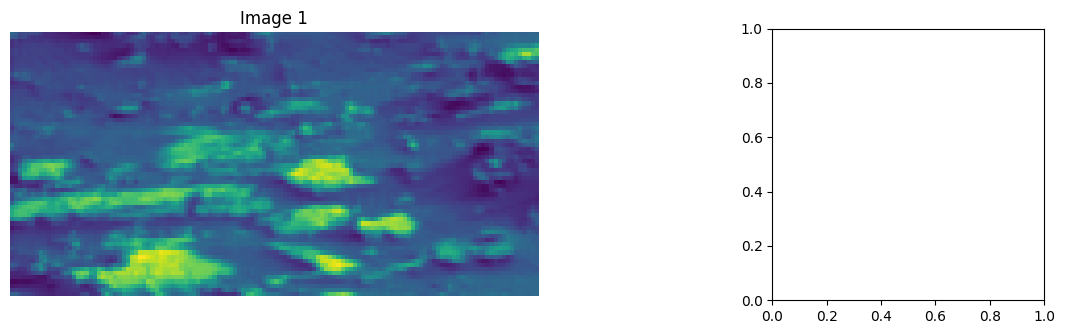

In [15]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

def plot_sample_batch(dataset, num_samples=3):
    """
    Display some image and label pairs from the dataset.
    """
    plt.figure(figsize=(15, 4*num_samples))

    for images, labels in dataset.take(1):
        labels_np = labels.numpy()
        num_classes = len(np.unique(labels_np))
        colormap = create_segmentation_colormap(num_classes)

        for j in range(min(num_samples, len(images))):
            # Plot original image
            plt.subplot(num_samples, 2, j*2 + 1)
            plt.imshow(images[j])
            plt.title(f'Image {j+1}')
            plt.axis('off')

            # Plot colored label
            plt.subplot(num_samples, 2, j*2 + 2)
            colored_label = apply_colormap(labels_np[j], colormap)
            plt.imshow(colored_label)
            plt.title(f'Label {j+1}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()
    plt.close()

# Visualize examples from the training set
print("Visualizing examples from the training set:")
plot_sample_batch(train_dataset, num_samples=3)

## Build the Models

### Attention U-Net

In [21]:
def attention_block(x, g, inter_channel):
    # Generate query, key, and value tensors
    theta_x = tfkl.Conv2D(inter_channel, (1,1), padding='same')(x)   # Query
    phi_g = tfkl.Conv2D(inter_channel, (1,1), padding='same')(g)      # Key
    attn = tfkl.Activation('sigmoid')(tfkl.Add()([theta_x, phi_g]))   # Attention Map
    attn = tfkl.Conv2D(1, (1,1), padding='same')(attn)  # Value

    # Multiply attention map with the input feature map
    return tfkl.Multiply()([x, attn])


def attention_u_net(input_shape=input_shape, depth=4, d_conv_count=3, b_conv_count=3, u_conv_count=3, start_filter=32, skip_connections=True, dropout=0.2, NUM_CLASSES=5):

    # Input Layer
    inputs = tfkl.Input(shape=input_shape, name='input_layer')

    x = inputs
    skipped = []

    # Downsampling
    for i in range(depth):

        for j in range(d_conv_count):
            x = tfkl.Conv2D(filters=start_filter,
                            kernel_size=(3, 3),
                            strides=(1, 1),
                            padding='same')(x)
            x = tfkl.BatchNormalization()(x) 
            x = tfkl.ReLU()(x)

        if skip_connections:
            # Save the layer for skip connections
            skipped.append(x)

        x = tfkl.MaxPooling2D(pool_size=(2, 2))(x)
        x = tfkl.Dropout(dropout)(x)

        start_filter = start_filter * 2

    # Bottleneck
    for j in range(b_conv_count):
        x = tfkl.Conv2D(filters=start_filter,
                        kernel_size=(3, 3),
                        strides=(1, 1),
                        padding='same')(x)
        x = tfkl.BatchNormalization()(x) 
        x = tfkl.ReLU()(x)

    start_filter = start_filter // 2

    # Upsampling
    for i in range(depth):

        x = tfkl.UpSampling2D(2, interpolation='bilinear')(x)

        if skip_connections:
            # Apply attention mechanism to the skip connections
            x = attention_block(x, skipped[depth - i - 1], start_filter)

        x = tfkl.Dropout(dropout)(x)

        for j in range(u_conv_count):
            x = tfkl.Conv2D(filters=start_filter,
                            kernel_size=(3, 3),
                            strides=(1, 1),
                            padding='same')(x)
            x = tfkl.BatchNormalization()(x) 
            x = tfkl.ReLU()(x)

        start_filter = start_filter // 2

    # Output Layer
    outputs = tfkl.Conv2D(filters=NUM_CLASSES,
                          kernel_size=(1, 1),
                          strides=(1, 1),
                          padding='same',
                          activation='softmax',
                          name="output_layer")(x)

    model = Model(inputs, outputs, name='Attention_UNet')
    return model


### Regular U-Net

In [22]:
def u_net(input_shape=input_shape, depth=4, 
          d_conv_count = 3, b_conv_count = 3, u_conv_count = 3, 
          start_filter=32, skip_connections=True, dropout=0.2):

    # Input Layer
    inputs = tfkl.Input(shape=input_shape, name='input_layer')

    x = inputs
    skipped = []
    # Downsampling
    for i in range(depth):
        for j in range(d_conv_count):
            x = tfkl.Conv2D(filters=start_filter,
                            kernel_size=(3,3),
                            strides=(1, 1),
                            padding='same')(x)
            x = tfkl.BatchNormalization()(x) 
            x = tfkl.ReLU()(x)

        if skip_connections:
            # Save the layer for skip connections
            skipped.append(x)

        x = tfkl.MaxPooling2D(pool_size=(2,2))(x)
        x = tfkl.Dropout(dropout)(x)
        
        start_filter = start_filter * 2
    
    # Bottleneck
    for j in range(b_conv_count):
        x = tfkl.Conv2D(filters=start_filter,
                            kernel_size=(3,3),
                            strides=(1, 1),
                            padding='same')(x)
        x = tfkl.BatchNormalization()(x) 
        x = tfkl.ReLU()(x)
    
    start_filter = start_filter // 2

    # Upsampling
    for i in range(depth):
        x = tfkl.UpSampling2D(2, interpolation='bilinear')(x)

        if skip_connections:
            x = tfkl.Concatenate()([x, skipped[depth - i - 1]])

        x = tfkl.Dropout(dropout)(x)

        for j in range(u_conv_count):
            x = tfkl.Conv2D(filters=start_filter,
                            kernel_size=(3,3),
                            strides=(1, 1),
                            padding='same')(x)
            x = tfkl.BatchNormalization()(x) ## remove?
            x = tfkl.ReLU()(x)
        start_filter = start_filter // 2
    

    # Output Layer
    outputs = tfkl.Conv2D(filters=NUM_CLASSES,
                        kernel_size=(1,1),
                        strides=(1, 1),
                        padding='same',
                        activation='softmax',
                        name="output_layer")(x)
    
    model = tf.keras.Model(inputs, outputs, name='UNet')
    return model

### Dense U-Net

In [23]:
'''
References:
Paper: https://qims.amegroups.org/article/view/43519/html
Code: https://github.com/THUHoloLab/Dense-U-net/blob/master/Dense-U-net/Dense_U_net.py
'''

def dense_unet(input_shape=input_shape, depth=4, 
               d_conv_count = 3, u_conv_count = 3,
               start_filter=32, dropout=0.2):

    # Input Layer
    inputs = tfkl.Input(shape=input_shape, name='input_layer')

    next = inputs
    skipped = []

    # Downsampling
    for i in range(depth):
        # Now this is a Dense Block
        for j in range(d_conv_count):
            
            x = tfkl.Conv2D(filters=start_filter,
                            kernel_size=(3,3),
                            kernel_initializer="he_normal",
                            strides=(1, 1),
                            padding='same')(next)
            x = tfkl.BatchNormalization()(x) 
            conv_block = tfkl.ReLU()(x)
            next = tfkl.Concatenate()([conv_block, next]) 

        
        skipped.append(conv_block)

        x = tfkl.MaxPooling2D(pool_size=(2,2))(conv_block)
        next = tfkl.Dropout(dropout)(x)
        
        start_filter = start_filter * 2
    
    # Bottleneck
    x = tfkl.Conv2D(filters=start_filter,
                        kernel_size=(3,3),
                        strides=(1, 1),
                        kernel_initializer="he_normal",
                        padding='same')(next)
    x = tfkl.BatchNormalization()(x) ##### not sure
    x = tfkl.ReLU()(x)
    next = tfkl.Dropout(dropout)(x)
    
    start_filter = start_filter // 2

    # Upsampling
    for i in range(depth):
        x = tfkl.UpSampling2D(2, interpolation='bilinear')(next)
        x = tfkl.Concatenate()([x, skipped.pop()]) ## try without axis
        next = tfkl.Dropout(dropout)(x)

        # Dense Block again
        for j in range(u_conv_count):
            
            x = tfkl.Conv2D(filters=start_filter,
                            kernel_size=(3,3),
                            kernel_initializer="he_normal",
                            strides=(1, 1),
                            padding='same')(next)            
            x = tfkl.BatchNormalization()(x) 
            conv_block = tfkl.ReLU()(x)
            next = tfkl.Concatenate()([conv_block, next]) 
            
        start_filter = start_filter // 2
    
    # Output Layer
    outputs = tfkl.Conv2D(filters=NUM_CLASSES,
                        kernel_size=(1,1),
                        strides=(1, 1),
                        padding='same',
                        activation='sigmoid',
                        name="output_layer")(next)
    
    model = tf.keras.Model(inputs, outputs, name='Dense_UNet')
    return model
    

### Current in use model

In [36]:
model = attention_u_net()



# Print a detailed summary of the model with expanded nested layers and trainable parameters.

model.summary(expand_nested=True, show_trainable=True)

Model: "Attention_UNet"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_39         │ (None, 64, 128, │       320 │ input_layer[0… │   Y   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 64, 128, │       128 │ conv2d_39[0][… │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ re_lu_27 (ReLU)   │ (None, 64, 128, │         0 │ batch_normali… │   -   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_40         │ (None, 64, 128, │     9,248 │ re_lu_27[0][0] │   Y   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 64, 128, │       128 │ conv2d_40[0][… │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ re_lu_28 (ReLU)   │ (None, 64, 128, │         0 │ batch_normali… │   -   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_41         │ (None, 64, 128, │     9,248 │ re_lu_28[0][0] │   Y   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 64, 128, │       128 │ conv2d_41[0][… │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ re_lu_29 (ReLU)   │ (None, 64, 128, │         0 │ batch_normali… │   -   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d_4   │ (None, 32, 64,  │         0 │ re_lu_29[0][0] │   -   │
│ (MaxPooling2D)    │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ dropout_8         │ (None, 32, 64,  │         0 │ max_pooling2d… │   -   │
│ (Dropout)         │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_42         │ (None, 32, 64,  │    18,496 │ dropout_8[0][… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 32, 64,  │       256 │ conv2d_42[0][… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ re_lu_30 (ReLU)   │ (None, 32, 64,  │         0 │ batch_normali… │   -   │
│                   │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_43         │ (None, 32, 64,  │    36,928 │ re_lu_30[0][0] │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 32, 64,  │       256 │ conv2d_43[0][… │   Y 

 Total params: 11,270,569 (42.99 MB)

 Trainable params: 11,261,737 (42.96 MB)

 Non-trainable params: 8,832 (34.50 KB)

### Metrics

In [43]:
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)

        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0

        self.labels_to_exclude = labels_to_exclude


    def update_state(self, y_true, y_pred, sample_weight=None):

        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)
        y_true = tf.math.argmax(y_true, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels

        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

In [44]:
# https://stackoverflow.com/questions/65125670/implementing-multiclass-dice-loss-function
def dice_loss(y_true, y_pred, smooth=1e-7):
    '''
    Dice coefficient for X categories. Ignores background pixel label 0
    Pass to model as metric during compile statement
    '''
    # Remove the background class (class 0)
    y_true = y_true[..., 1:]  # Shape: [batch_size, height, width, num_classes - 1]
    y_pred = y_pred[..., 1:]  # Shape: [batch_size, height, width, num_classes - 1]
    
    # Flatten y_true and y_pred
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    # Compute intersection and denominator
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    
    return K.mean((2. * intersect / (denom + smooth)))

def dice_loss_multiclass(y_true, y_pred):
    '''
    Dice loss to minimize. Pass to model as loss during compile statement
    '''
    return 1 - dice_loss(y_true, y_pred)

def combined_multiclass_loss(y_true, y_pred, alpha=0.5, beta=0.5):
    dice = dice_loss_multiclass(y_true, y_pred)
    categorical_ce = tf.keras.losses.SparseCategoricalCrossentropy()(y_true, y_pred)
    return alpha * dice + beta * categorical_ce

In [45]:
# Compile the model

print("Compiling model...")

model.compile(
    loss= dice_loss_multiclass, #combined_multiclass_loss,#keras.losses.CategoricalFocalCrossentropy(), #dice_loss_multiclass, #tf.keras.losses.Dice, #tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)

print("Model compiled!")

Compiling model...
Model compiled!


## 🛠️ Train the Model

In [46]:
# Setup callbacks

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    mode="auto",
    min_lr=1e-5
)

In [ ]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
).history

print("\nFinished")

In [48]:
# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

Final validation Mean Intersection Over Union: 41.95%


In [49]:
# Save the trained model to a file with the accuracy included in the filename

model_filename = 'model.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

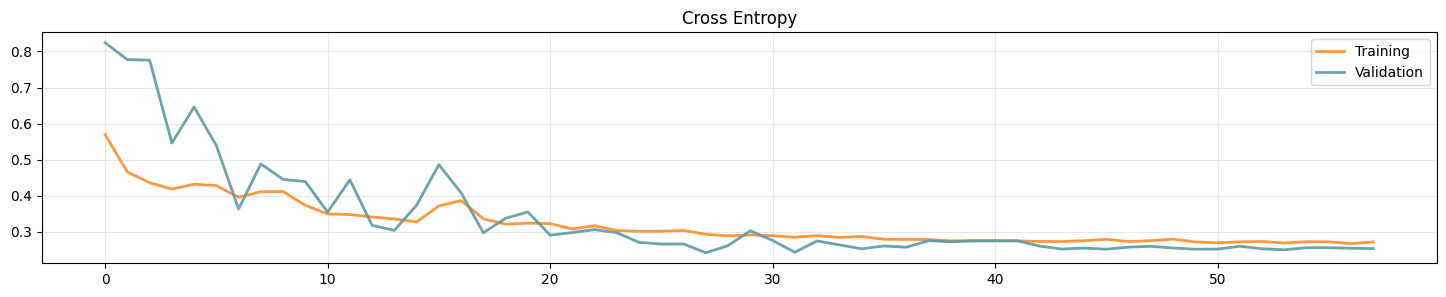

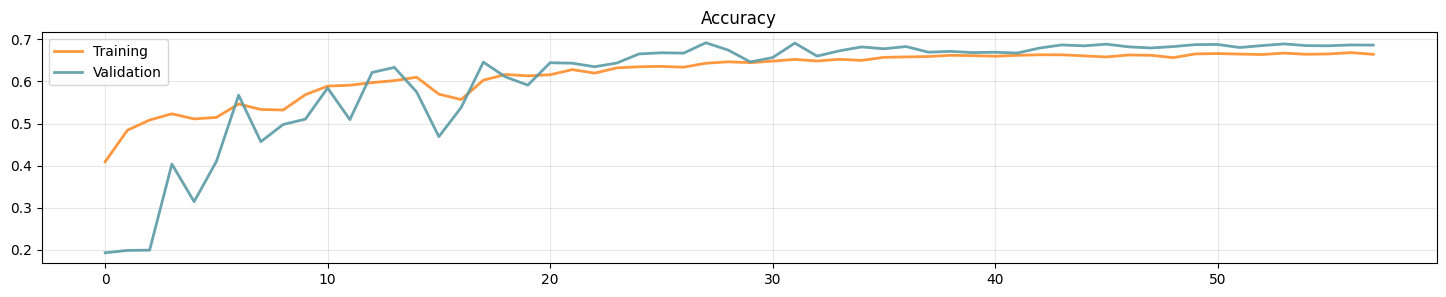

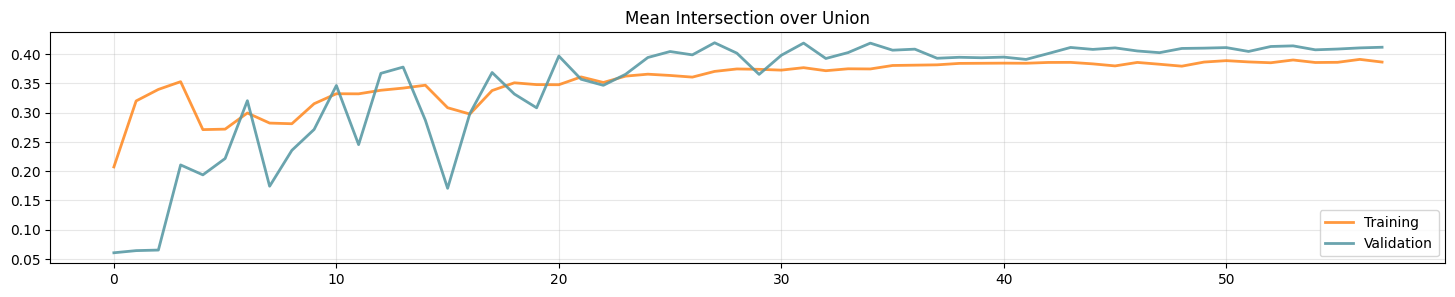

In [50]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))

plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)

plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)

plt.title('Mean Intersection over Union')

plt.legend()

plt.grid(alpha=0.3)

plt.show()

## 📊 Prepare Your Submission



In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.




In [54]:
X_test_submission = data["test_set"]
print(f"Test X shape: {X_test_submission.shape}")
X_test_submission = X_test_submission[..., np.newaxis] / 255.0
X_test_submission = tf.cast(X_test_submission, tf.float32)
X_test_submission = tf.image.grayscale_to_rgb(X_test_submission)

Test X shape: (10022, 64, 128)


In [55]:
# Load UNet model without compiling
model = tfk.models.load_model('/kaggle/working/model.keras', compile=False)

# Compile the model with specified loss, optimizer, and metrics
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tfk.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

Model: "Attention_UNet"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_39         │ (None, 64, 128, │       320 │ input_layer[0… │   Y   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 64, 128, │       128 │ conv2d_39[0][… │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ re_lu_27 (ReLU)   │ (None, 64, 128, │         0 │ batch_normali… │   -   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_40         │ (None, 64, 128, │     9,248 │ re_lu_27[0][0] │   Y   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 64, 128, │       128 │ conv2d_40[0][… │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ re_lu_28 (ReLU)   │ (None, 64, 128, │         0 │ batch_normali… │   -   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_41         │ (None, 64, 128, │     9,248 │ re_lu_28[0][0] │   Y   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 64, 128, │       128 │ conv2d_41[0][… │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ re_lu_29 (ReLU)   │ (None, 64, 128, │         0 │ batch_normali… │   -   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d_4   │ (None, 32, 64,  │         0 │ re_lu_29[0][0] │   -   │
│ (MaxPooling2D)    │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ dropout_8         │ (None, 32, 64,  │         0 │ max_pooling2d… │   -   │
│ (Dropout)         │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_42         │ (None, 32, 64,  │    18,496 │ dropout_8[0][… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 32, 64,  │       256 │ conv2d_42[0][… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ re_lu_30 (ReLU)   │ (None, 32, 64,  │         0 │ batch_normali… │   -   │
│                   │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_43         │ (None, 32, 64,  │    36,928 │ re_lu_30[0][0] │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 32, 64,  │       256 │ conv2d_43[0][… │   Y 

 Total params: 11,270,569 (42.99 MB)

 Trainable params: 11,261,737 (42.96 MB)

 Non-trainable params: 8,832 (34.50 KB)

In [56]:
preds = model.predict(X_test_submission)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

ValueError: Exception encountered when calling Functional.call().

[1mInput 0 of layer "conv2d_39" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (32, 64, 128, 3)[0m

Arguments received by Functional.call():
  • inputs=tf.Tensor(shape=(32, 64, 128, 3), dtype=float32)
  • training=False
  • mask=None

In [ ]:
def y_to_df(y) -> pd.DataFrame:

    """Converts segmentation predictions into a DataFrame format for Kaggle."""

    n_samples = len(y)

    y_flat = y.reshape(n_samples, -1)

    df = pd.DataFrame(y_flat)

    df["id"] = np.arange(n_samples)

    cols = ["id"] + [col for col in df.columns if col != "id"]

    return df[cols]


In [ ]:
# Create and download the csv submission file

filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.csv'

submission_df = y_to_df(preds)

submission_df.to_csv(filename, index=False)

filename